## 01 Import modules

In [1]:
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import pearsonr

#### [Opt] Vars

In [3]:
PATH = r'/PATH/TO/FORMATTED/FILES'
data_list = []

#### [Opt] Funcs

In [4]:
def set_dtypes(df):
    df['id'] = df['id'].astype('Int32')
    df['mbti_profile'] = df['mbti_profile'].astype('string')
    df['contributor_create_date'] = df['contributor_create_date'].astype('string')
    df['is_active'] = df['is_active'].astype('bool')
    df['is_approved'] = df['is_approved'].astype('bool')
    df['mbti_type'] = df['mbti_type'].astype('category')
    df['watch_count'] = df['watch_count'].astype('Int32')
    df['comment_count'] = df['comment_count'].astype('Int32')
    df['vote_count_mbti'] = df['vote_count_mbti'].astype('Int32')
    df['total_vote_counts'] = df['total_vote_counts'].astype('Int32')
    df['cat_id'] = df['cat_id'].astype('Int8')
    df['category'] = df['category'].astype('category')
    df['sub_cat_id'] = df['sub_cat_id'].astype('Int32')
    df['subcategory'] = df['subcategory'].astype('category')
    df['functions'] = df['functions'].astype('string')
    df['category_is_fictional'] = df['category_is_fictional'].astype('bool')
    return df

#### [Opt] Read data from JSONs

In [ ]:
ct = 0
for file in os.listdir(PATH):
        if (ct % 10000) == 0:
                print(f'{ct} file done')
        if file.endswith(".json"):
                with open(rf'{PATH}/{file}') as f:
                        data = json.load(f)
                data_list.append(data)
                ct += 1

#### [Opt] Create Dataframe

In [6]:
dataframe = pd.DataFrame(data_list)
dataframe['mbti_type']= dataframe.mbti_type.str.split(' ').str[0]
dataframe = set_dtypes(dataframe)

#### [Opt] Store Dataframe with Feather

In [7]:
dataframe.to_feather('complete.feather')

## 02 Load Data from Feather file

In [ ]:
dataframe=pd.read_feather('../../resources/complete.feather')

## 03 Clear Data
518476 datapoints

In [8]:
dataframe.info()

categories = dataframe["category"].unique()
for category in categories:
    print(category)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518476 entries, 0 to 518475
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   id                       518476 non-null  Int32   
 1   mbti_profile             518476 non-null  string  
 2   contributor_create_date  518476 non-null  string  
 3   is_active                518476 non-null  bool    
 4   is_approved              518476 non-null  bool    
 5   mbti_type                518476 non-null  category
 6   watch_count              518476 non-null  Int32   
 7   comment_count            518476 non-null  Int32   
 8   vote_count_mbti          518476 non-null  Int32   
 9   total_vote_counts        518476 non-null  Int32   
 10  cat_id                   518476 non-null  Int8    
 11  category                 518476 non-null  category
 12  sub_cat_id               518476 non-null  Int32   
 13  subcategory              518476 non-null  ca

### 03.1 Reduce to fictional categories
360 538 datapoint remaining

In [31]:
fictional_df = dataframe.query("category_is_fictional == True").copy()
fictional_df = fictional_df.query("category not in ['Music', 'Archetypes', 'Interests', 'Settings', 'Plots', 'Franchises', 'Theories', 'Polls (If you...)', 'Your Experience', 'Type Combo (Your Type)', 'Ask PDB', 'PDB Community']").copy()

fictional_df.info

<bound method DataFrame.info of             id      mbti_profile contributor_create_date  is_active   
0       371080    Alexander Garb     2021-08-05 07:54:34       True  \
1            1    Jerry Seinfeld     2015-05-19 20:41:44       True   
2           10       Ross Geller     2015-05-21 21:46:54       True   
3          100      Buster Bluth     2015-06-04 23:46:07       True   
5        10000     Munehisa Iwai     2018-02-12 21:02:50       True   
...        ...               ...                     ...        ...   
518466   99973           Gustafa     2020-02-19 03:53:39       True   
518468   99974             Hardy     2020-02-19 03:53:52       True   
518470  999744   Karen V. Morris     2023-01-15 20:48:31       True   
518471   99975  Kiyomi Azumabito     2020-02-19 03:54:02       True   
518473   99976              Hugh     2020-02-19 03:54:06       True   

        is_approved mbti_type  watch_count  comment_count  vote_count_mbti   
0              True      XXXX        

### 03.2 Remove entries with small amount of votes
Threshhold "2":\
202 045 datapoints remaining

<class 'pandas.core.frame.DataFrame'>
Index: 202045 entries, 1 to 518471
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   id                       202045 non-null  Int32   
 1   mbti_profile             202045 non-null  string  
 2   contributor_create_date  202045 non-null  string  
 3   is_active                202045 non-null  bool    
 4   is_approved              202045 non-null  bool    
 5   mbti_type                202045 non-null  category
 6   watch_count              202045 non-null  Int32   
 7   comment_count            202045 non-null  Int32   
 8   vote_count_mbti          202045 non-null  Int32   
 9   total_vote_counts        202045 non-null  Int32   
 10  cat_id                   202045 non-null  Int8    
 11  category                 202045 non-null  category
 12  sub_cat_id               202045 non-null  Int32   
 13  subcategory              202045 non-null  categor

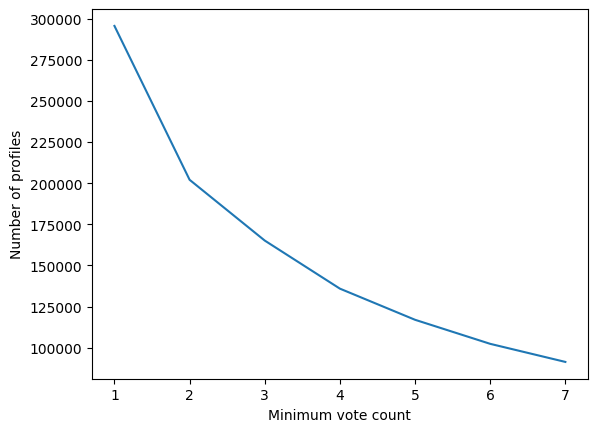

In [10]:
THRESHHOLD = 2
reduced_df = fictional_df.query(f"vote_count_mbti >= {THRESHHOLD}").copy()
reduced_df.info()

thresholds = range(1, 8)
profile_counts = []

for threshold in thresholds:
    filtered_df = fictional_df[fictional_df['vote_count_mbti'] >= threshold]
    profile_counts.append(len(filtered_df))

plt.plot(thresholds, profile_counts)
plt.xlabel('Minimum vote count')
plt.ylabel('Number of profiles')
plt.show()

### 03.3 Remove entries where mbti_type is uncertain (i.e. contains char 'x')

186 655 datapoints remaining

In [11]:
rows_to_drop = reduced_df[reduced_df.mbti_type.str.contains('X|^\s*$', regex=True, case=False)].copy()
reduced_df = reduced_df.drop(rows_to_drop.index).copy()
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186655 entries, 1 to 518471
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   id                       186655 non-null  Int32   
 1   mbti_profile             186655 non-null  string  
 2   contributor_create_date  186655 non-null  string  
 3   is_active                186655 non-null  bool    
 4   is_approved              186655 non-null  bool    
 5   mbti_type                186655 non-null  category
 6   watch_count              186655 non-null  Int32   
 7   comment_count            186655 non-null  Int32   
 8   vote_count_mbti          186655 non-null  Int32   
 9   total_vote_counts        186655 non-null  Int32   
 10  cat_id                   186655 non-null  Int8    
 11  category                 186655 non-null  category
 12  sub_cat_id               186655 non-null  Int32   
 13  subcategory              186655 non-null  categor

## 04 Analysis

### 4.1 Overall Data
186 655 datapoints
22.3+ MB

In [12]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186655 entries, 1 to 518471
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   id                       186655 non-null  Int32   
 1   mbti_profile             186655 non-null  string  
 2   contributor_create_date  186655 non-null  string  
 3   is_active                186655 non-null  bool    
 4   is_approved              186655 non-null  bool    
 5   mbti_type                186655 non-null  category
 6   watch_count              186655 non-null  Int32   
 7   comment_count            186655 non-null  Int32   
 8   vote_count_mbti          186655 non-null  Int32   
 9   total_vote_counts        186655 non-null  Int32   
 10  cat_id                   186655 non-null  Int8    
 11  category                 186655 non-null  category
 12  sub_cat_id               186655 non-null  Int32   
 13  subcategory              186655 non-null  categor

### 4.2 Data per Category
Fictional Categories only:
- Anime & Manga            : 32162
- Cartoons                 : 16628
- Comics                   : 1309
- Gaming                   : 36159
- Literature               : 13928
- Movies                   : 27624
- Superheroes              : 3404
- Television               : 44306
- Theatre                  : 1424
- Web Comics               : 9711

In [13]:
reduced_df.groupby('category', observed=True)['id'].count()

category
Anime & Manga    32162
Cartoons         16628
Comics            1309
Gaming           36159
Literature       13928
Movies           27624
Superheroes       3404
Television       44306
Theatre           1424
Web Comics        9711
Name: id, dtype: int64

### 4.3 Highest occurences of mbti_types in fictional corpus

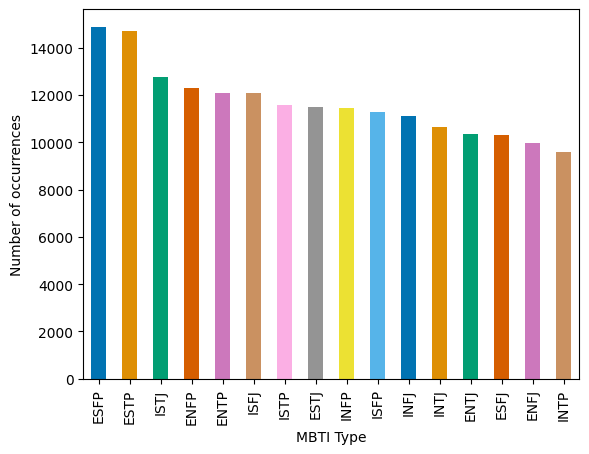

0: ESFP - 14894
1: ESTP - 14728
2: ISTJ - 12781
3: ENFP - 12301
4: ENTP - 12100
5: ISFJ - 12093
6: ISTP - 11566
7: ESTJ - 11510
8: INFP - 11446
9: ISFP - 11282
10: INFJ - 11101
11: INTJ - 10651
12: ENTJ - 10334
13: ESFJ - 10301
14: ENFJ - 9964
15: INTP - 9603


In [14]:
grouped_df = reduced_df.groupby('mbti_type', observed=True)['id'].count()
ax = grouped_df.sort_values(ascending=False).plot(kind='bar', color=sns.color_palette('colorblind', len(grouped_df)))
ax.set_xlabel('MBTI Type')
ax.set_ylabel('Number of occurrences')
plt.show()

for i, (mbti_type, count) in enumerate(grouped_df.sort_values(ascending=False).items()):
    print(f"{i}: {mbti_type} - {count}")

#### 4.3.1 Highest number of votes of mbti_types in fictional corpus

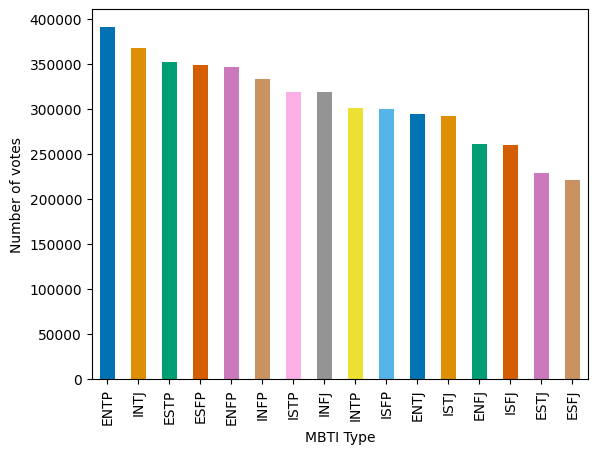

In [15]:
grouped_df = reduced_df.groupby('mbti_type', observed=True)['vote_count_mbti'].sum()
ax = grouped_df.sort_values(ascending=False).plot(kind='bar', color=sns.color_palette('colorblind', len(grouped_df)))
ax.set_xlabel('MBTI Type')
ax.set_ylabel('Number of votes')
plt.show()

### 4.4a Highest occurences of mbti_types by category in numbers

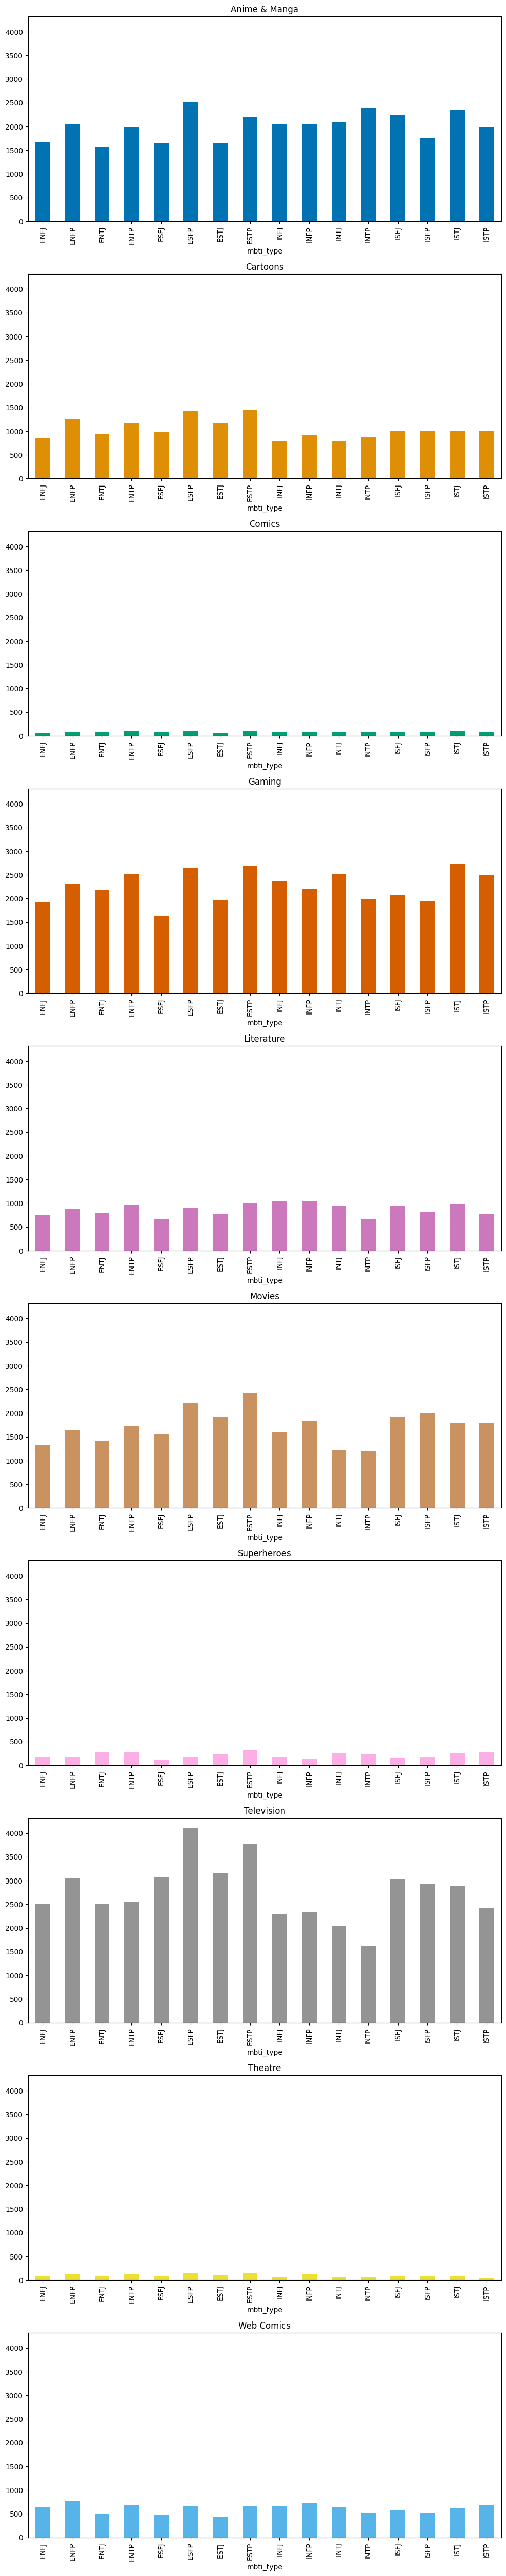

In [54]:
pivot = reduced_df.pivot_table(\
    index=['mbti_type'],\
    columns=['category'],\
    values='id',\
    aggfunc={'id': 'count'},\
    observed=True)

pivot.plot(\
    subplots=True,\
    sharey=True,\
    layout=(20,1),\
    figsize=(10,100),\
    kind='bar',\
    color=sns.color_palette('colorblind'),\
    sharex=False,\
    legend=False)

plt.tight_layout()

### 4.4b Highest occurences of mbti_types by category (values only)

In [16]:
pivot = reduced_df.pivot_table(\
    index=['mbti_type'],\
    columns=['category'],\
    values='id',\
    aggfunc={'id': 'count'},\
    observed=True)

pivot = pivot.assign(Sum=pivot.sum(axis=1))
print(pivot)
pivot.to_csv("output.c")

category   Anime & Manga  Cartoons  Comics  Gaming  Literature  Movies   
mbti_type                                                                
ENFJ                1677       843      58    1923         745    1320  \
ENFP                2038      1250      79    2294         873    1648   
ENTJ                1567       941      86    2185         784    1420   
ENTP                1989      1171      98    2524         958    1736   
ESFJ                1657       984      71    1628         668    1558   
ESFP                2510      1426      97    2641         913    2224   
ESTJ                1640      1170      68    1973         776    1933   
ESTP                2196      1450      93    2686        1009    2416   
INFJ                2053       788      78    2362        1043    1597   
INFP                2044       909      77    2196        1040    1839   
INTJ                2084       788      86    2522         941    1231   
INTP                2384       884    

### 4.4c Highest occurences of mbti_types by category in numbers (percentage only)

In [17]:
pivot = reduced_df.pivot_table(\
    index=['mbti_type'],\
    columns=['category'],\
    values='id',\
    aggfunc={'id': 'count'},\
    observed=True)

total = pivot.sum().sum()
pivot_percent = pivot.apply(lambda x: x/total*100)
pivot_percent.loc['Total',:] = pivot_percent.sum(axis=0)
pivot_percent['Total'] = pivot_percent.sum(axis=1)
print(pivot_percent)

category   Anime & Manga  Cartoons    Comics     Gaming  Literature   
mbti_type                                                             
ENFJ            0.898449  0.451635  0.031073   1.030243    0.399132  \
ENFP            1.091854  0.669685  0.042324   1.229005    0.467708   
ENTJ            0.839517  0.504139  0.046074   1.170609    0.420026   
ENTP            1.065602  0.627361  0.052503   1.352227    0.513246   
ESFJ            0.887734  0.527176  0.038038   0.872197    0.357880   
ESFP            1.344727  0.763976  0.051968   1.414910    0.489138   
ESTJ            0.878626  0.626825  0.036431   1.057030    0.415740   
ESTP            1.176502  0.776834  0.049825   1.439019    0.540569   
INFJ            1.099890  0.422169  0.041788   1.265436    0.558785   
INFP            1.095068  0.486995  0.041253   1.176502    0.557178   
INTJ            1.116498  0.422169  0.046074   1.351156    0.504139   
INTP            1.277223  0.473601  0.037502   1.067745    0.354665   
ISFJ  

In [57]:
pivot = reduced_df.pivot_table(
    index=['mbti_type'],
    columns=['category'],
    values='id',
    aggfunc={'id': 'count'},
    observed=True)

row_sums = pivot.sum(axis=1)
pivot_percent = pivot.div(row_sums, axis=0) * 100
print(pivot_percent)

category   Anime & Manga   Cartoons    Comics     Gaming  Literature   
mbti_type                                                              
ENFJ           16.830590   8.460458  0.582096  19.299478    7.476917  \
ENFP           16.567759  10.161775  0.642224  18.648890    7.096984   
ENTJ           15.163538   9.105864  0.832204  21.143797    7.586607   
ENTP           16.438017   9.677686  0.809917  20.859504    7.917355   
ESFJ           16.085817   9.552471  0.689253  15.804291    6.484807   
ESFP           16.852424   9.574325  0.651269  17.731973    6.129985   
ESTJ           14.248480  10.165074  0.590791  17.141616    6.741964   
ESTP           14.910375   9.845193  0.631450  18.237371    6.850896   
INFJ           18.493829   7.098460  0.702639  21.277362    9.395550   
INFP           17.857767   7.941639  0.672724  19.185742    9.086144   
INTJ           19.566238   7.398366  0.807436  23.678528    8.834851   
INTP           24.825575   9.205457  0.728939  20.753931    6.89

### 4.5 Number of subcategories

In [18]:
num_unique_subcategories = len(reduced_df['subcategory'].dropna().unique())
print('Number of unique subcategories:', num_unique_subcategories)

Number of unique subcategories: 22440


### 4.6 Twenty subcategories with the highest amount of MBTI votes

In [19]:
subcategory_votes = reduced_df.groupby('subcategory')['vote_count_mbti'].sum()
top_subcategories = subcategory_votes.sort_values(ascending=False).head(20)

print('Top 20 subcategories by collective vote_count_mbti:')
print(top_subcategories)

Top 20 subcategories by collective vote_count_mbti:
subcategory
Genshin Impact                          91875
Naruto Shippūden                        49657
Boku no Hero Academia                   47478
Shingeki no Kyojin                      47259
MCU: The Heroes                         38742
Bungou Stray Dogs                       36644
Harry Potter / Wizarding World Films    33796
Kimetsu no Yaiba                        33407
Stranger Things                         31955
Hunter X Hunter                         31516
Haikyuu!!                               31370
JoJo no Kimyou na Bouken                29654
Death Note                              29323
Game of Thrones (2011)                  27601
Avatar: The Last Airbender (2005)       27308
Jujutsu Kaisen                          26638
Tokyo Revengers                         26606
Chainsaw Man                            23782
One Piece                               23249
Star Wars                               21641
Name: vote_count

#### 4.6.1 MBTI Type distribution 

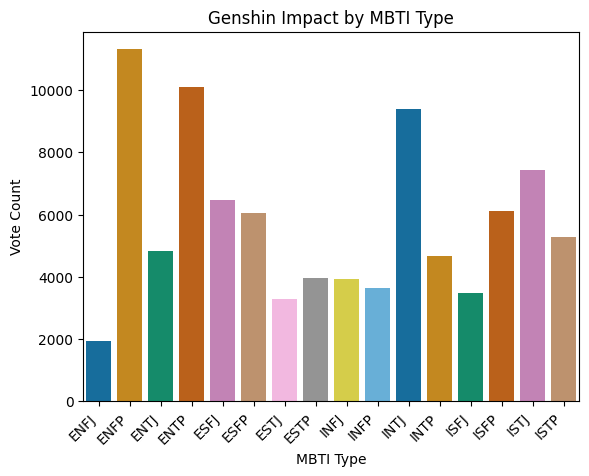

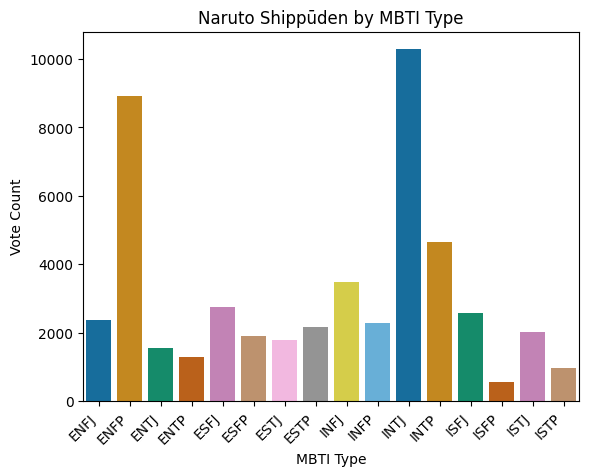

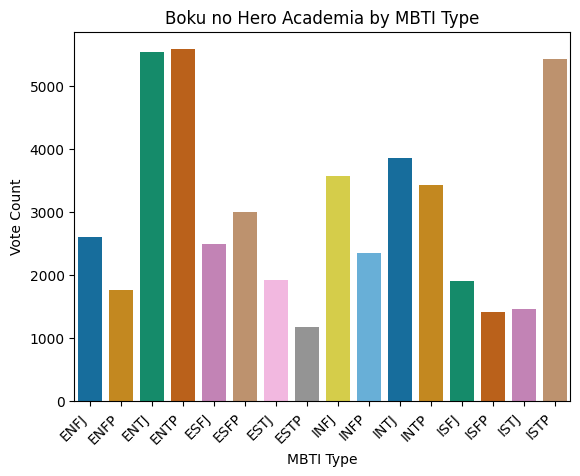

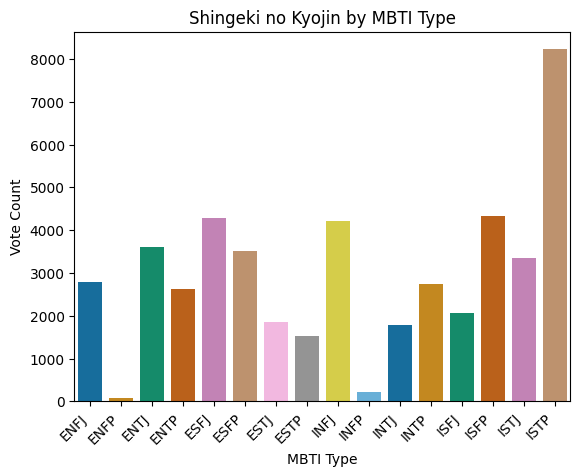

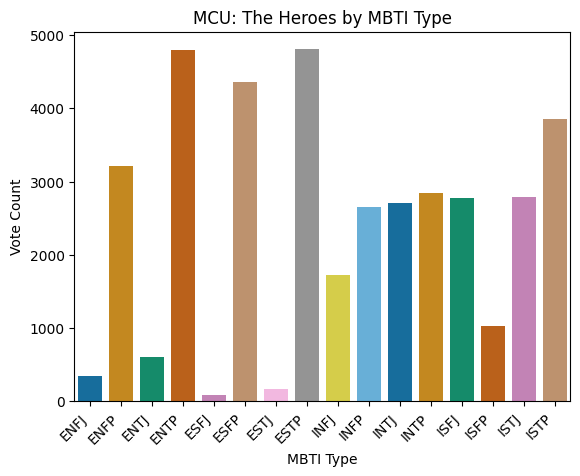

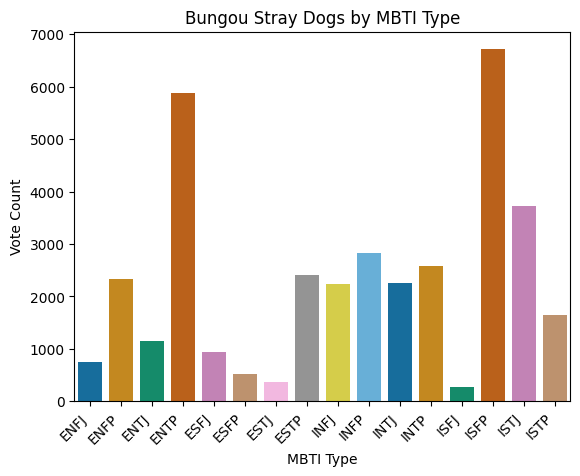

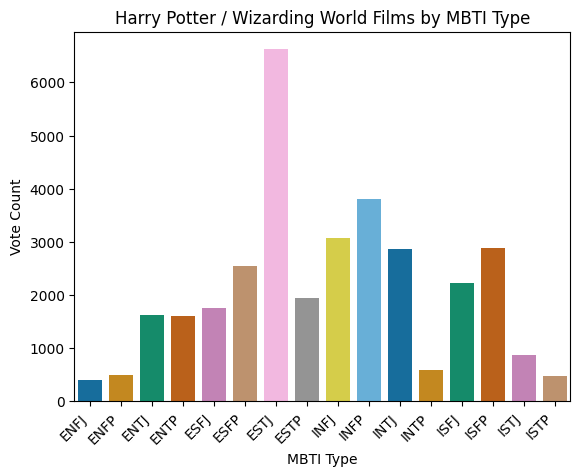

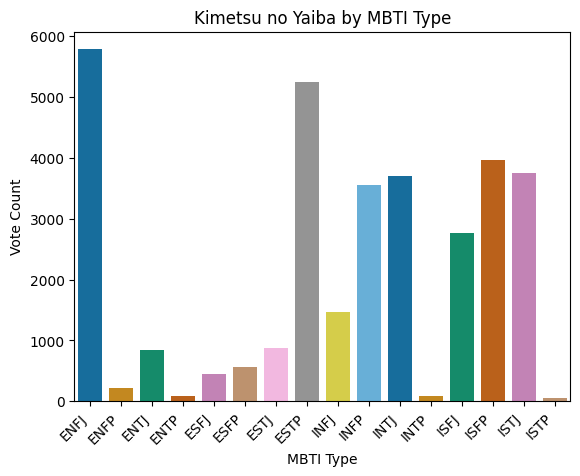

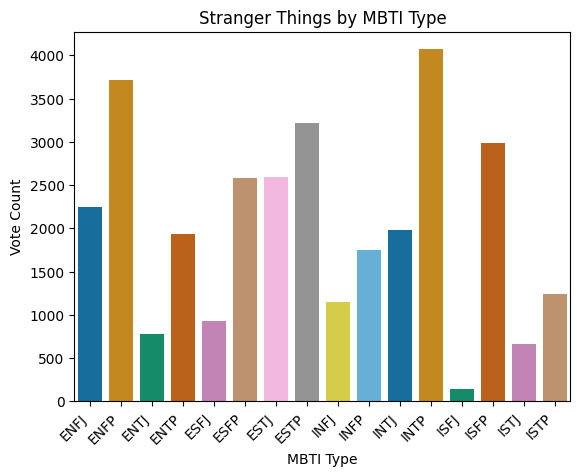

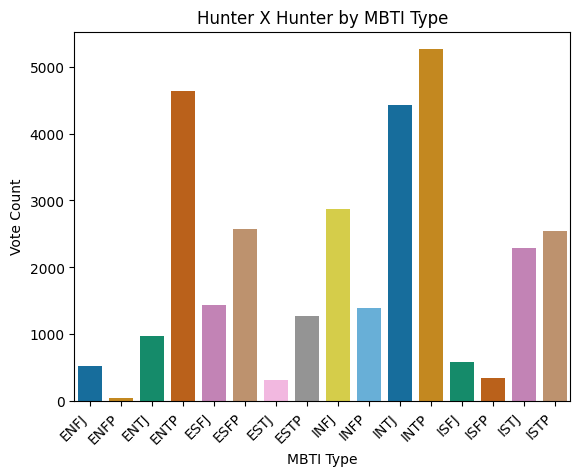

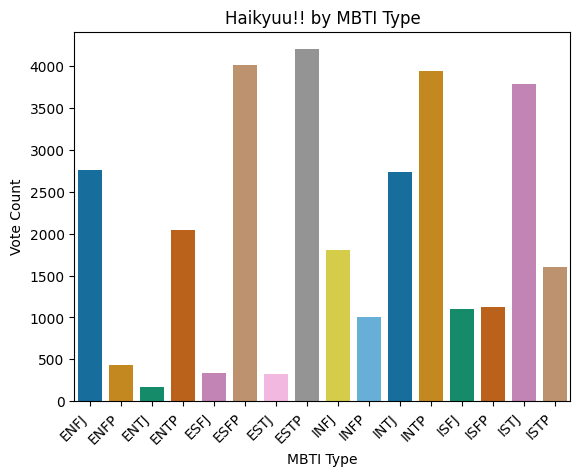

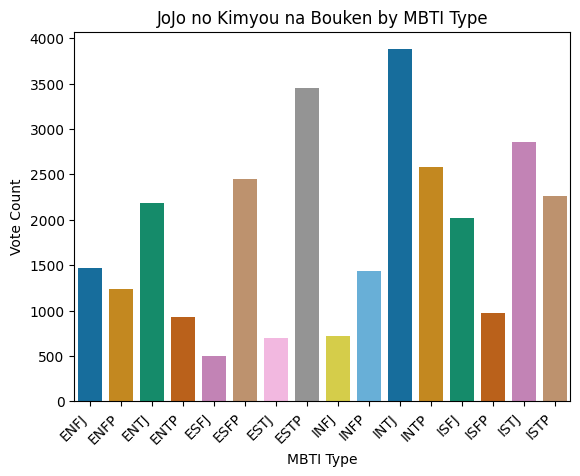

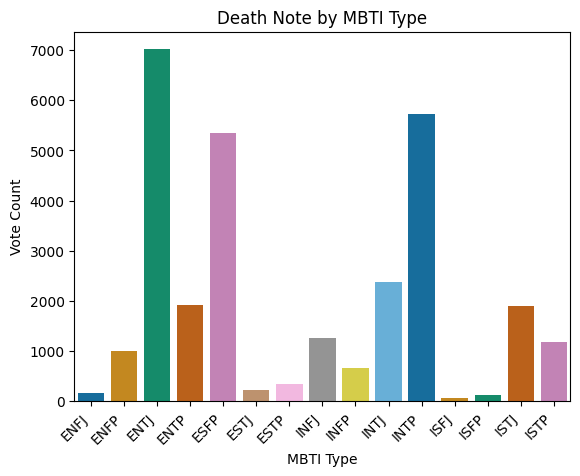

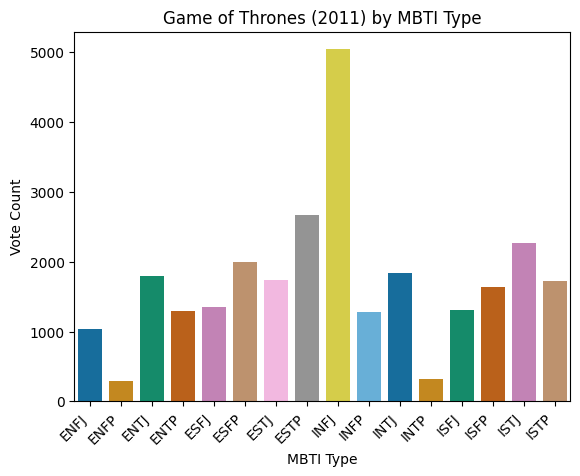

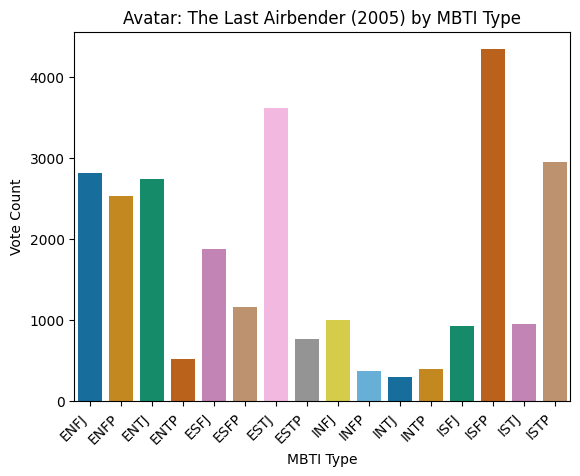

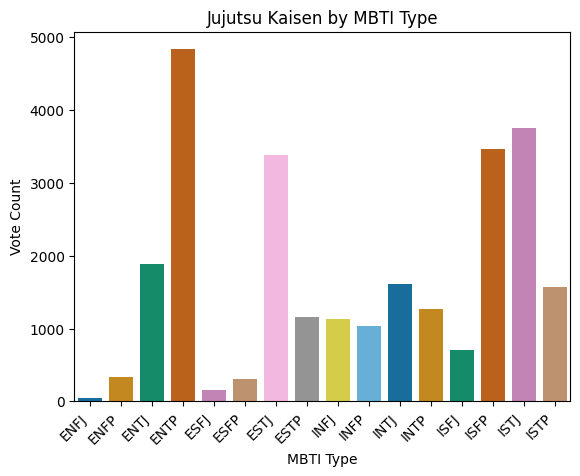

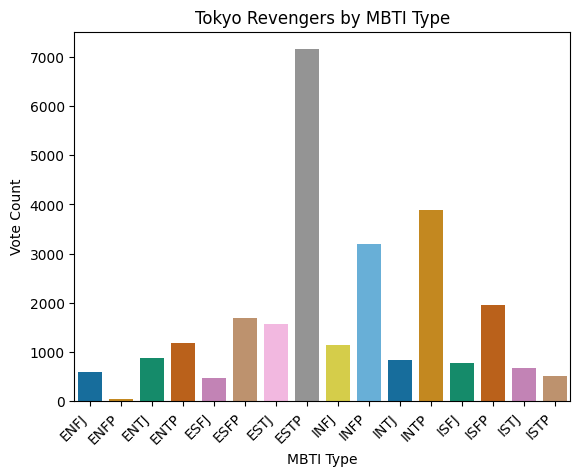

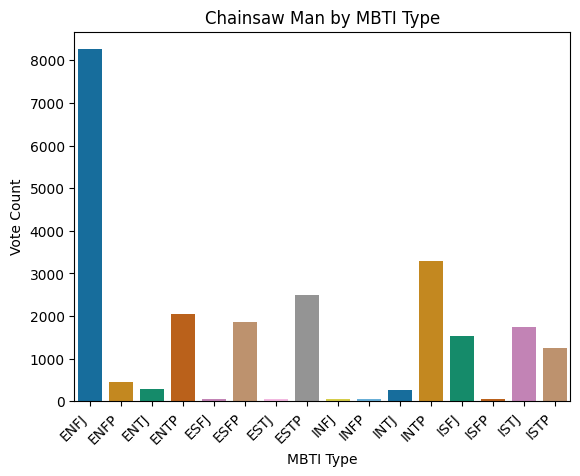

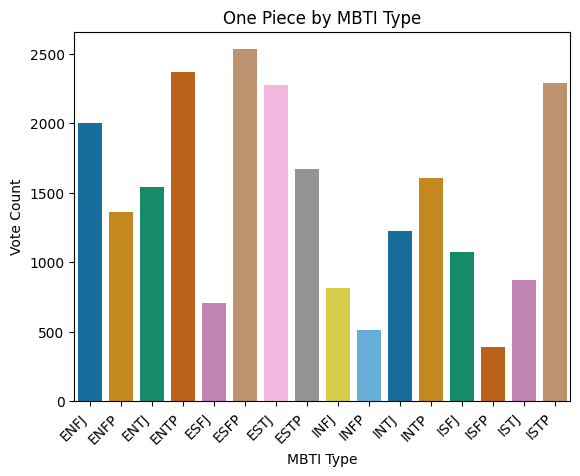

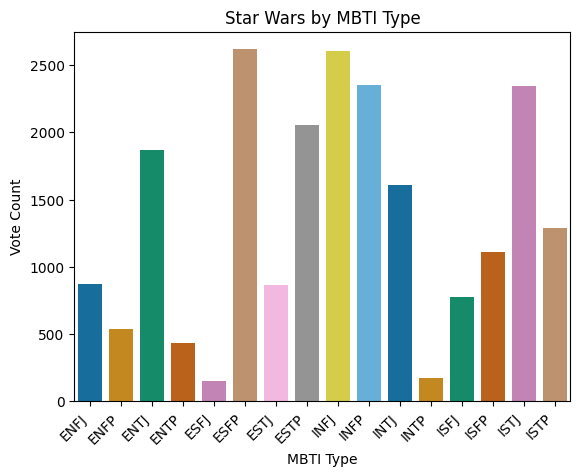

In [60]:
subcategory_votes = reduced_df.groupby('subcategory', observed=True)['vote_count_mbti'].sum()
top_subcategories = subcategory_votes.sort_values(ascending=False).head(20)

for subcategory in top_subcategories.index:
    subcategory_df = reduced_df[reduced_df['subcategory'] == subcategory]
    mbti_votes = subcategory_df.groupby('mbti_type', observed=True)['vote_count_mbti'].sum()
    
    palette = sns.color_palette("colorblind", len(mbti_votes))
    ax = sns.barplot(x=mbti_votes.index.remove_unused_categories(), y=mbti_votes.values, palette=palette)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set(title=f"{subcategory} by MBTI Type", xlabel='MBTI Type', ylabel='Vote Count')
    plt.show()

#### 4.6.2 Top 3 most voted franchise and their MBTI distribution for each category

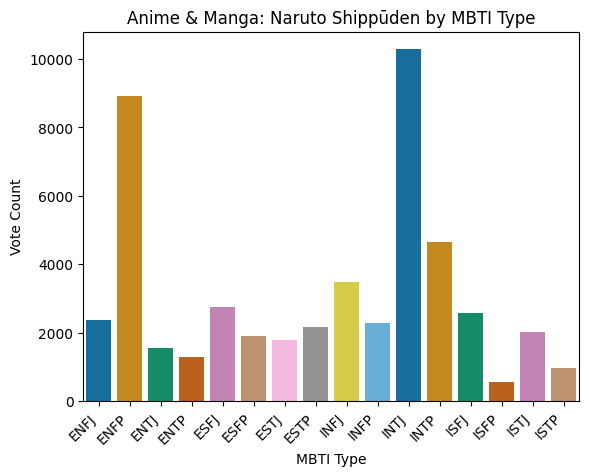

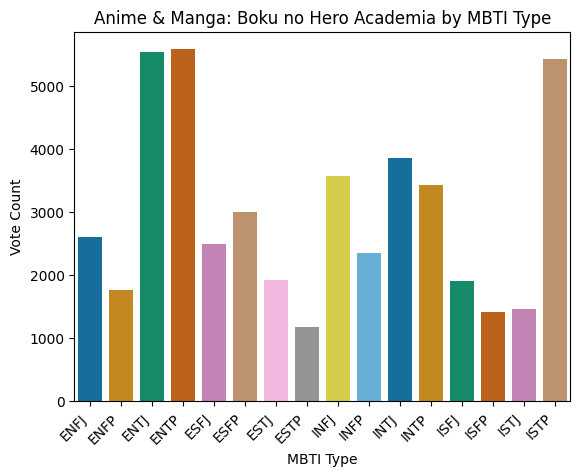

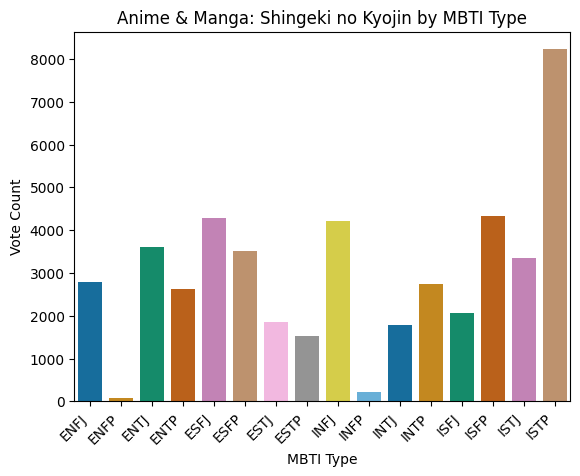

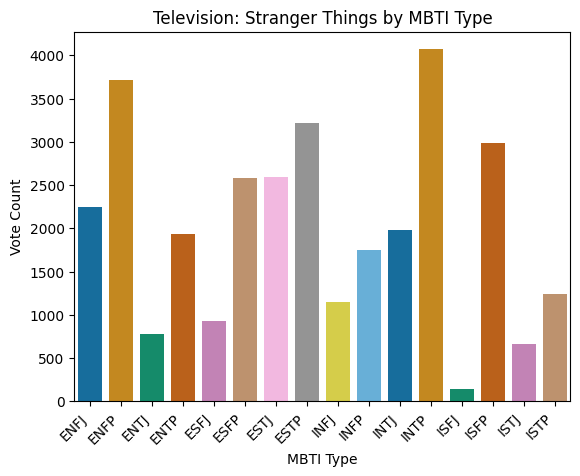

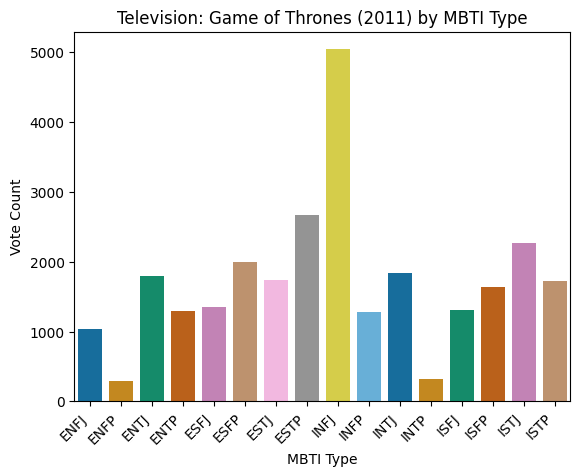

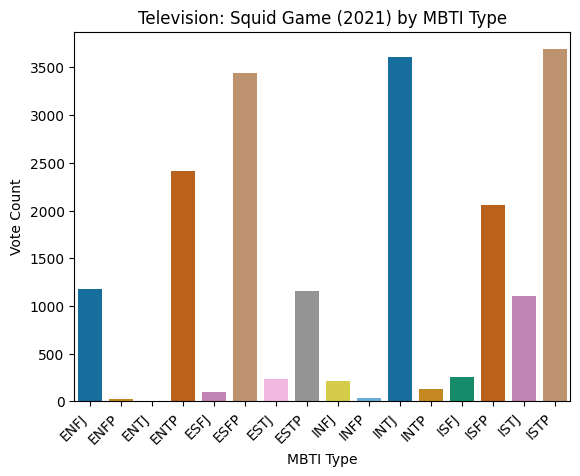

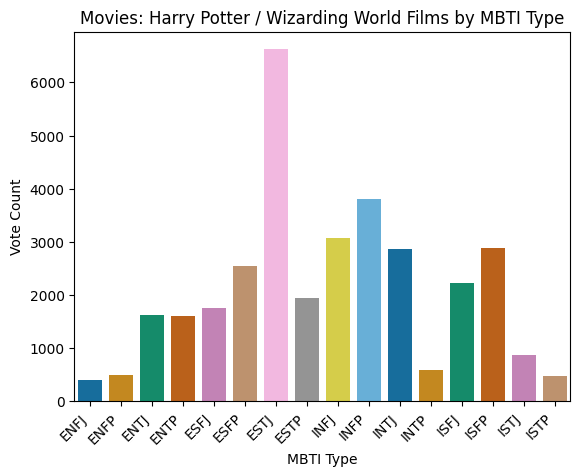

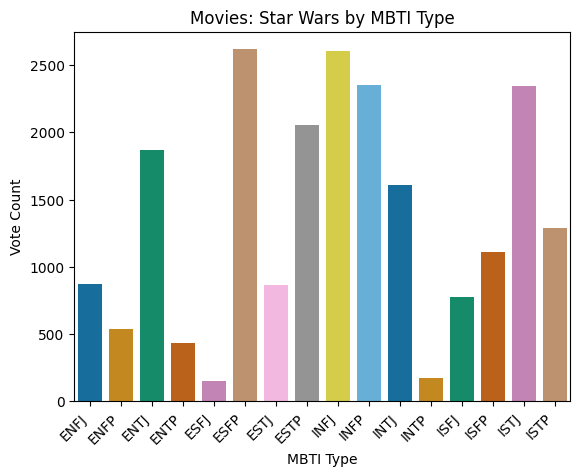

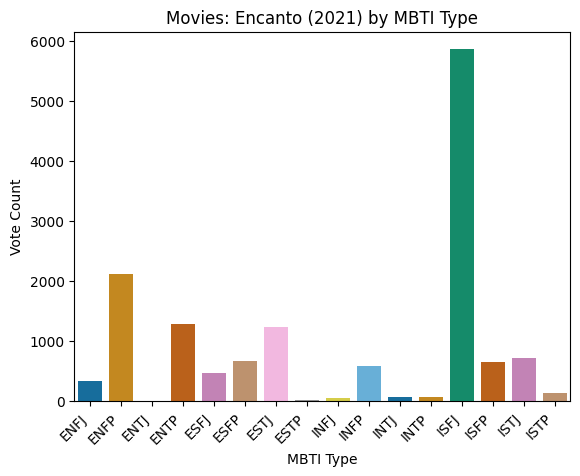

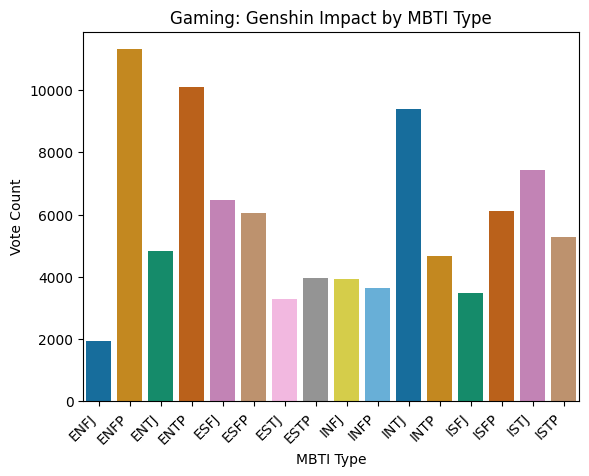

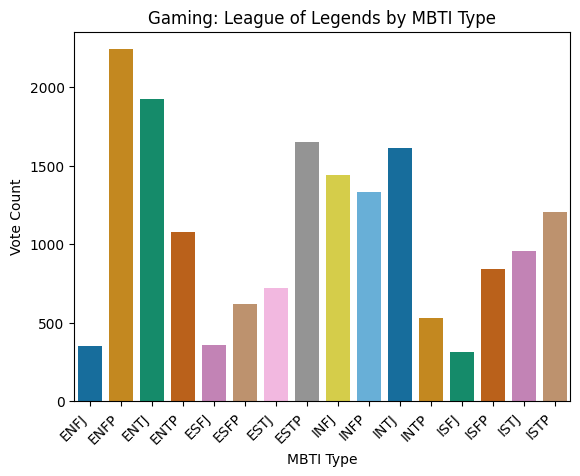

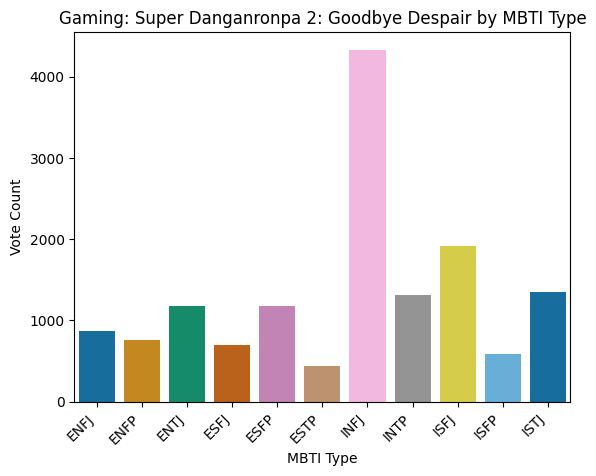

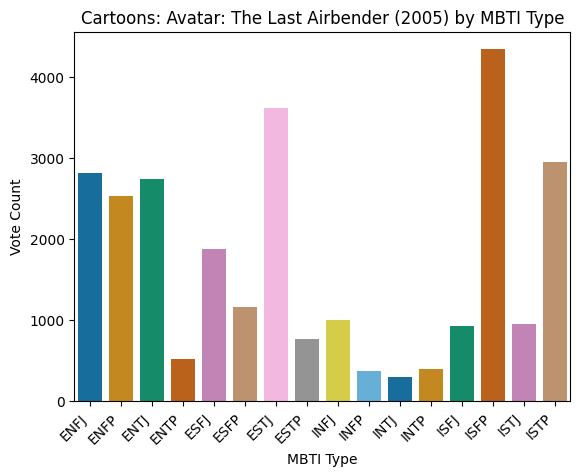

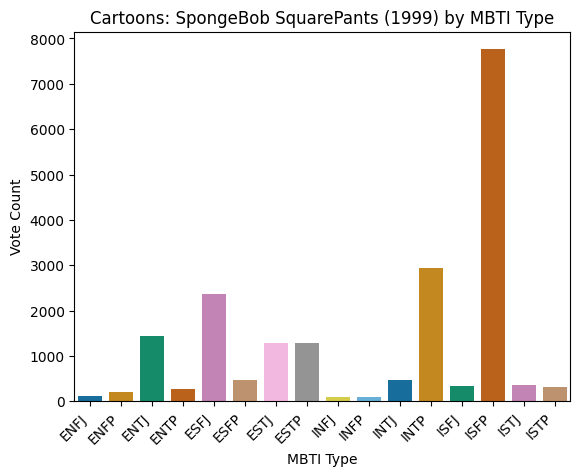

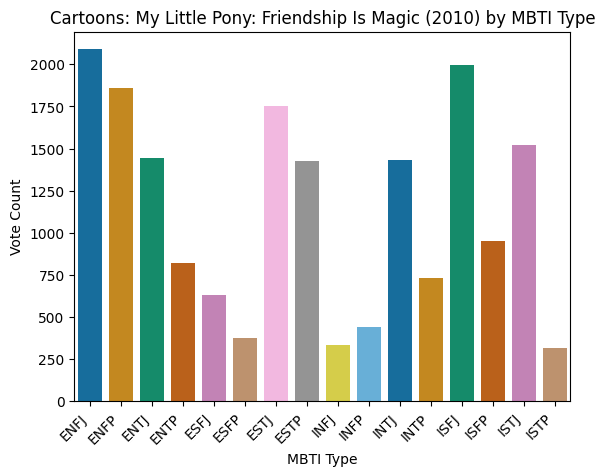

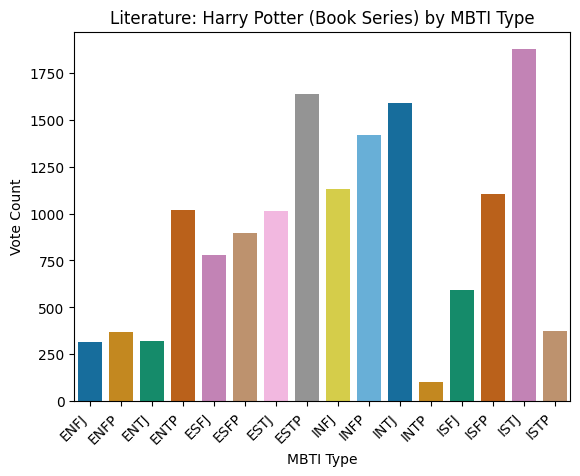

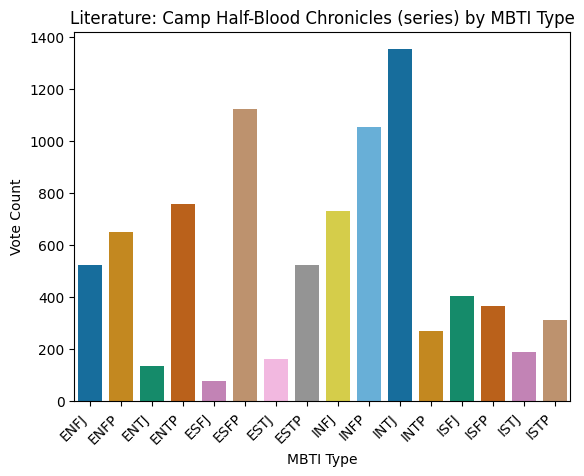

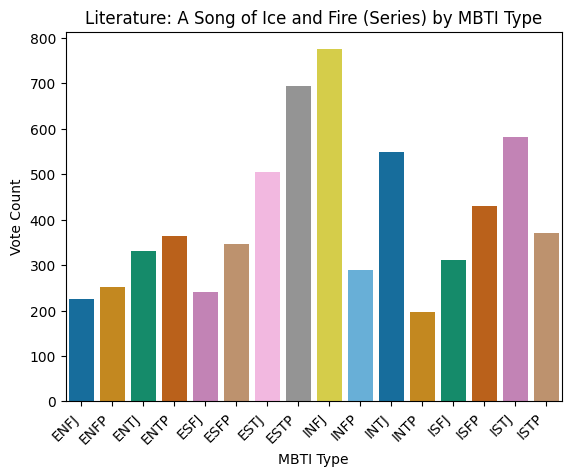

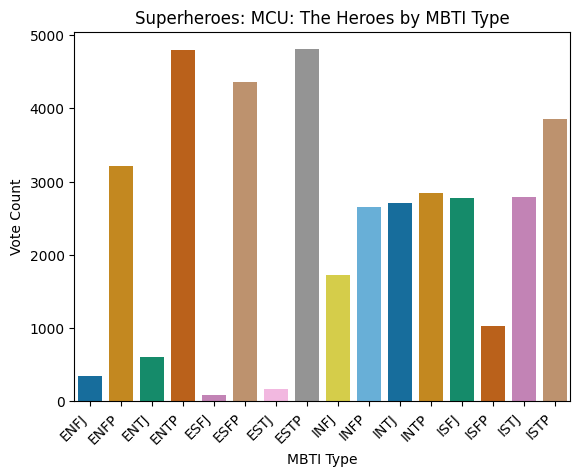

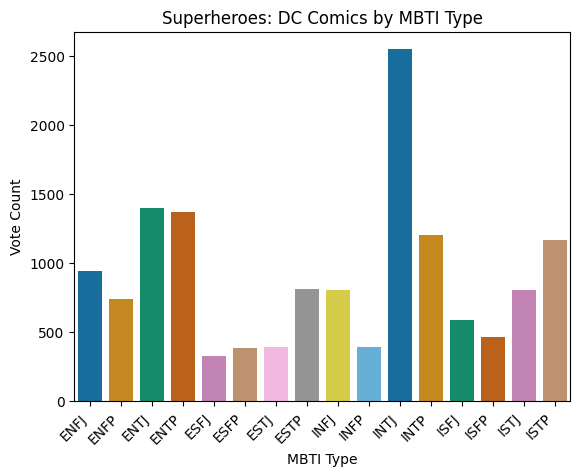

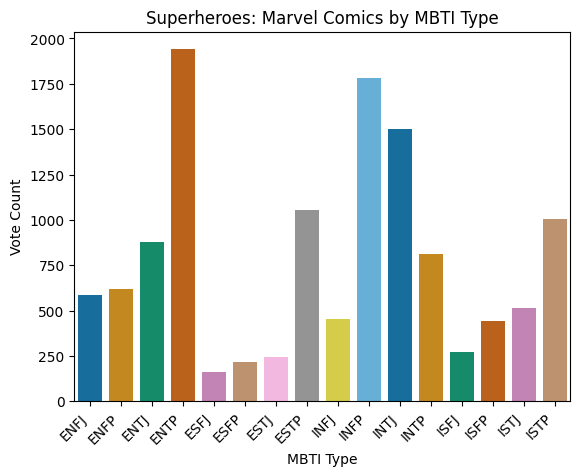

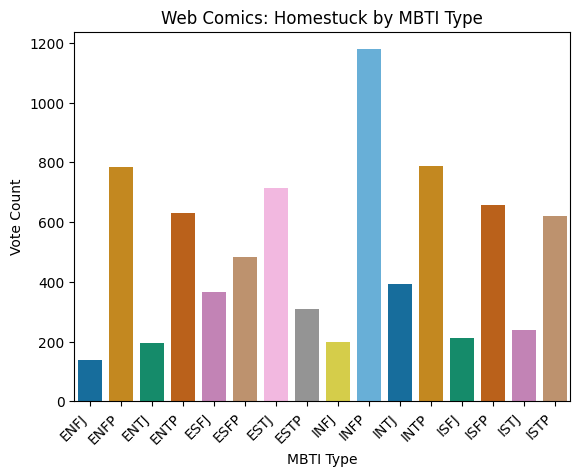

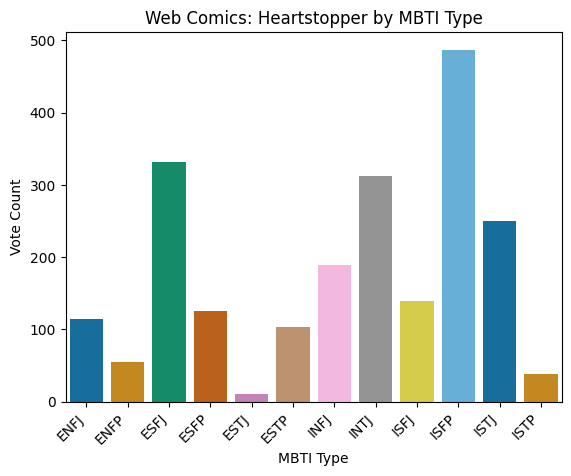

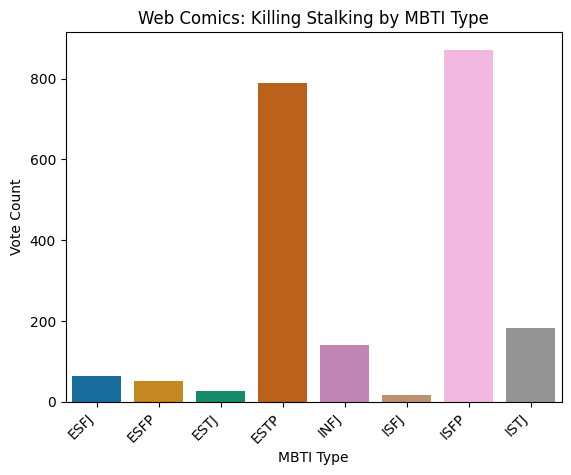

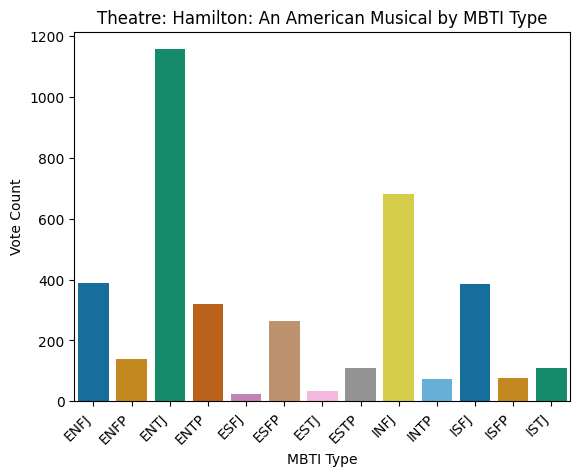

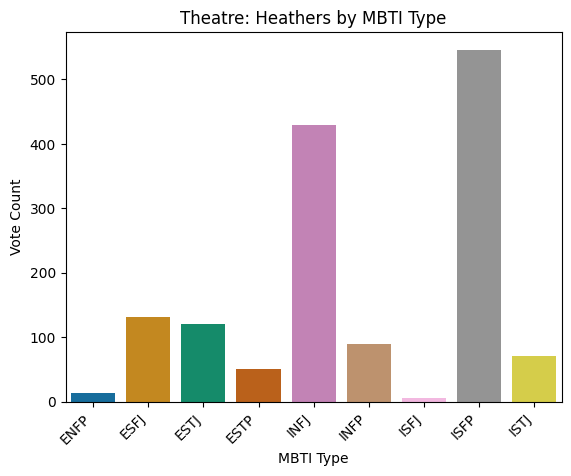

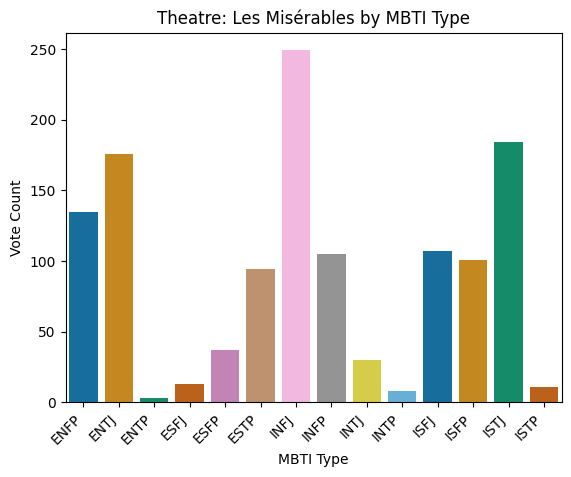

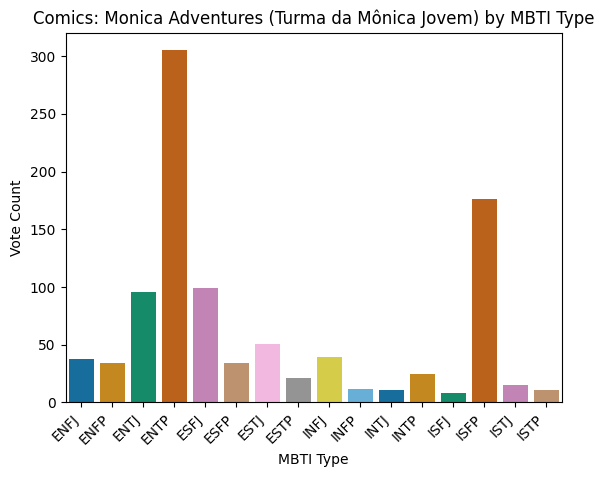

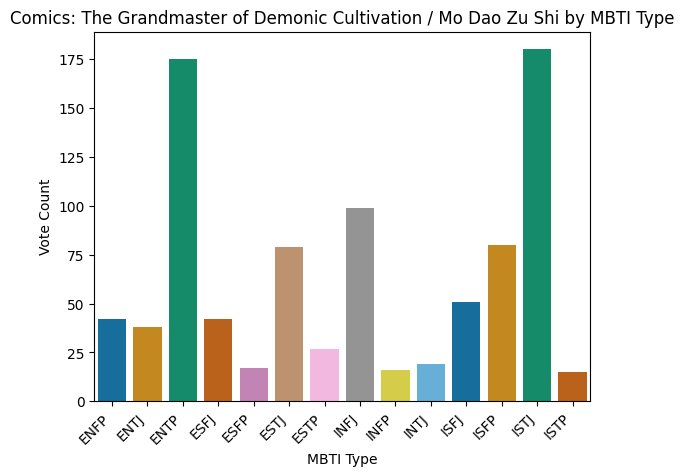

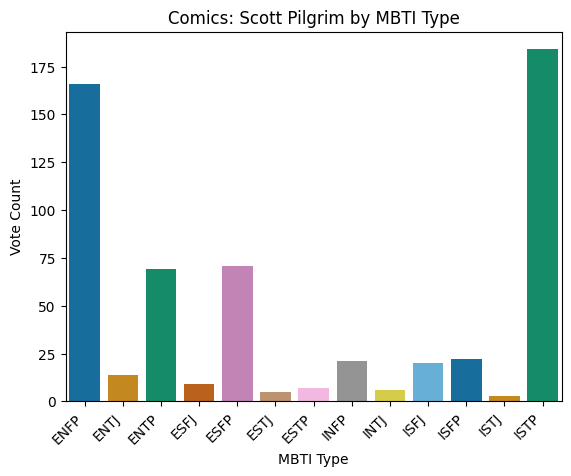

In [20]:
category_votes = reduced_df.groupby('category', observed=True)['vote_count_mbti'].sum()
top_categories = category_votes.sort_values(ascending=False)

for category in top_categories.index:
    subcategory_votes = reduced_df[reduced_df['category'] == category].groupby('subcategory', observed=True)['vote_count_mbti'].sum()
    top_subcategories = subcategory_votes.sort_values(ascending=False).head(3)
    
    for subcategory in top_subcategories.index:
        subcategory_df = reduced_df[(reduced_df['category'] == category) & (reduced_df['subcategory'] == subcategory)]
        mbti_votes = subcategory_df.groupby('mbti_type', observed=True)['vote_count_mbti'].sum()

        palette = sns.color_palette("colorblind", len(mbti_votes))
        ax = sns.barplot(x=mbti_votes.index.remove_unused_categories(), y=mbti_votes.values, palette=palette)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set(title=f"{category}: {subcategory} by MBTI Type", xlabel='MBTI Type', ylabel='Vote Count')
        plt.show()


#### 4.6.2 Top 20 subcategories with the highest collective vote_count_mbti 

In [62]:
top_subcategories = reduced_df.groupby('subcategory')['vote_count_mbti'].sum().sort_values(ascending=False).head(20)
print('Top 20 subcategories with the highest collective vote_count_mbti:')
print(top_subcategories)

for subcategory in top_subcategories.index:
    subcategory_df = reduced_df[reduced_df['subcategory'] == subcategory]
    num_unique_profiles = subcategory_df['id'].nunique()
    print(f"{subcategory}: {num_unique_profiles} unique profiles")

Top 20 subcategories with the highest collective vote_count_mbti:
subcategory
Genshin Impact                          91875
Naruto Shippūden                        49657
Boku no Hero Academia                   47478
Shingeki no Kyojin                      47259
MCU: The Heroes                         38742
Bungou Stray Dogs                       36644
Harry Potter / Wizarding World Films    33796
Kimetsu no Yaiba                        33407
Stranger Things                         31955
Hunter X Hunter                         31516
Haikyuu!!                               31370
JoJo no Kimyou na Bouken                29654
Death Note                              29323
Game of Thrones (2011)                  27601
Avatar: The Last Airbender (2005)       27308
Jujutsu Kaisen                          26638
Tokyo Revengers                         26606
Chainsaw Man                            23782
One Piece                               23249
Star Wars                               21641
Na

### 4.7 Statistics: Mean, median, max, and min for general votes, mbti votes, mbti types category, subcategory

In [64]:
mean_vote_count = reduced_df['total_vote_counts'].mean()
median_vote_count = reduced_df['total_vote_counts'].median()
max_vote_count = reduced_df['total_vote_counts'].max()
min_vote_count = reduced_df['total_vote_counts'].min()

print(f"Average vote count: {mean_vote_count}")
print(f"Median vote count: {median_vote_count}")
print(f"Max vote count: {max_vote_count}")
print(f"Min vote count: {min_vote_count}")

mean_mbti_vote_count = reduced_df['vote_count_mbti'].mean()
median_mbti_vote_count = reduced_df['vote_count_mbti'].median()
max_mbti_vote_count = reduced_df['vote_count_mbti'].max()
min_mbti_vote_count = reduced_df['vote_count_mbti'].min()

print(f"Average mbti vote count: {mean_mbti_vote_count}")
print(f"Median mbti vote count: {median_mbti_vote_count}")
print(f"Max mbti vote count: {max_mbti_vote_count}")
print(f"Min mbti vote count: {min_mbti_vote_count}")

total_votes = reduced_df['vote_count_mbti'].sum()
print(f"Total number of votes: {total_votes}")

votes_per_category = reduced_df.groupby('category', observed=True)['vote_count_mbti'].sum()
print("Number of votes per category:")
print(votes_per_category)

category_stats = reduced_df.groupby('category', observed=True)['vote_count_mbti'].agg(['median', 'mean', 'min', 'max', 'count'])
print(category_stats)

mbti_category_stats = pd.pivot_table(reduced_df, index='category', columns='mbti_type', values='vote_count_mbti', aggfunc='count', fill_value=0, observed=True)

category_stats = []
for category in mbti_category_stats.index.remove_unused_categories():
    category_df = mbti_category_stats.loc[[category]]
    category_stats.append(category_df.agg(['median', 'mean', 'min', 'max', 'count']).T)
    
mbti_category_stats = pd.concat(category_stats, axis=1, keys=mbti_category_stats.index)
print("MBTI stats for each category and mbti_type:")
print(mbti_category_stats)


Average vote count: 54.556277624494385
Median vote count: 12.0
Max vote count: 17737
Min vote count: 2
Average mbti vote count: 26.403932388631432
Median mbti vote count: 6.0
Max mbti vote count: 8671
Min mbti vote count: 2
Total number of votes: 4928426
Number of votes per category:
category
Anime & Manga    1301359
Cartoons          504236
Comics             11675
Gaming            728982
Literature        205473
Movies            761049
Superheroes       166679
Television       1075549
Theatre            21580
Web Comics        151844
Name: vote_count_mbti, dtype: Int32
               median       mean  min   max  count
category                                          
Anime & Manga     7.0  40.462627    2  8671  32162
Cartoons          6.0  30.324513    2  7672  16628
Comics            4.0   8.919022    2   244   1309
Gaming            5.0  20.160458    2  7925  36159
Literature        4.0  14.752513    2  1695  13928
Movies            6.0  27.550282    2  4700  27624
Superheroes 

### 4.8 Popularity and MBTI type correlation

In [65]:
correlation_df = reduced_df.copy()
enc = OrdinalEncoder(dtype=int)
correlation_df['mbti_type'] = enc.fit_transform(correlation_df[['mbti_type']])
correlation_df = correlation_df[['total_vote_counts', 'mbti_type']]

imputer = SimpleImputer(strategy='mean')
correlation_df['total_vote_counts'] = imputer.fit_transform(correlation_df[['total_vote_counts']])
correlation_df['total_vote_counts'] = pd.to_numeric(correlation_df['total_vote_counts'])
correlation_df.dropna(inplace=True)
corr, pvalue = pearsonr(correlation_df['total_vote_counts'], correlation_df['mbti_type'])

print(f'Correlation coefficient: {corr:.6f}')
print(f'p-value: {pvalue:.6f}')

Correlation coefficient: -0.001893
p-value: 0.413564


#### 4.8.1 Most popular characters in the corpus

In [66]:
character_votes = reduced_df.groupby('id').agg({
    'vote_count_mbti': 'sum',
    'mbti_profile': 'first',
    'mbti_type': 'first',
    'category': 'first',
    'subcategory': 'first'
})

top_characters = character_votes.sort_values('vote_count_mbti', ascending=False).head(30)

for character_id, row in top_characters.iterrows():
    print(f"Votes {row['vote_count_mbti']} votes")
    print(f"Name: {row['mbti_profile']}")
    print(f"Category: {row['category']} and Subcategory: {row['subcategory']}")
    print(f"MBTI Type: {row['mbti_type']}\n")

Votes 8671 votes
Name: Sasuke Uchiha
Category: Anime & Manga and Subcategory: Naruto Shippūden
MBTI Type: INTJ

Votes 7925 votes
Name: Venti
Category: Gaming and Subcategory: Genshin Impact
MBTI Type: ENFP

Votes 7925 votes
Name: Makima
Category: Anime & Manga and Subcategory: Chainsaw Man
MBTI Type: ENFJ

Votes 7672 votes
Name: Squidward Tentacles
Category: Cartoons and Subcategory: SpongeBob SquarePants (1999)
MBTI Type: ISFP

Votes 7277 votes
Name: Naruto Uzumaki
Category: Anime & Manga and Subcategory: Naruto Shippūden
MBTI Type: ENFP

Votes 6914 votes
Name: Light Yagami
Category: Anime & Manga and Subcategory: Death Note
MBTI Type: ENTJ

Votes 5669 votes
Name: Ray
Category: Anime & Manga and Subcategory: Yakusoku no Neverland
MBTI Type: INTP

Votes 5582 votes
Name: L
Category: Anime & Manga and Subcategory: Death Note
MBTI Type: INTP

Votes 5533 votes
Name: Ryunosuke Akutagawa
Category: Anime & Manga and Subcategory: Bungou Stray Dogs
MBTI Type: ISFP

Votes 5333 votes
Name: Osamu 

### 4.9 Differences between Movies, Books, etc.

In [67]:
subcat_count = reduced_df.groupby('subcategory')['category'].nunique().reset_index()
subcat_count = subcat_count[subcat_count['category'] > 1]
subcat_votes = reduced_df.groupby('subcategory')['vote_count_mbti'].sum().reset_index()
subcat_votes = subcat_votes[subcat_votes['subcategory'].isin(subcat_count['subcategory'])]
subcat_votes = subcat_votes.sort_values(by='vote_count_mbti', ascending=False).head(20)

subcat_merge = pd.merge(subcat_count, subcat_votes, on='subcategory')

num_matching_pairs = 0
num_nonmatching_pairs = 0

for subcat in subcat_merge['subcategory']:
    subcat_profiles = reduced_df[reduced_df['subcategory'] == subcat]
    
    name_count = subcat_profiles['mbti_profile'].value_counts()
    name_count = name_count[name_count > 1]
    
    for name in name_count.index:
        profiles = subcat_profiles[subcat_profiles['mbti_profile'] == name]
        if len(set(profiles['category'])) > 1:
            types = set(profiles['mbti_type'])
            if len(types) > 1:
                print(f"Profiles with the same name '{name}' but different categories in subcategory '{subcat}' have different MBTI types:")
                for index, row in profiles.iterrows():
                    print(f"  Category: {row['category']}, MBTI Type: {row['mbti_type']}")
                print()
                num_nonmatching_pairs += 1
            else:
                num_matching_pairs += 1

print(f"Number of matching MBTI profile pairs: {num_matching_pairs}")
print(f"Number of non-matching MBTI profile pairs: {num_nonmatching_pairs}")

Profiles with the same name 'Irie Kyosuke' but different categories in subcategory 'Higurashi no Naku Koro ni' have different MBTI types:
  Category: Gaming, MBTI Type: INTP
  Category: Anime & Manga, MBTI Type: ESFJ

Profiles with the same name 'Rina Mamiya' but different categories in subcategory 'Higurashi no Naku Koro ni' have different MBTI types:
  Category: Gaming, MBTI Type: ESTP
  Category: Anime & Manga, MBTI Type: ESFP

Profiles with the same name 'Kumagai Katsuya' but different categories in subcategory 'Higurashi no Naku Koro ni' have different MBTI types:
  Category: Anime & Manga, MBTI Type: INTP
  Category: Gaming, MBTI Type: INTJ

Profiles with the same name 'Amy March' but different categories in subcategory 'Little Women' have different MBTI types:
  Category: Literature, MBTI Type: ESFP
  Category: Theatre, MBTI Type: ENTJ

Profiles with the same name 'Elizabeth "Beth" March' but different categories in subcategory 'Little Women' have different MBTI types:
  Categor

## 05 Actors

### 5.1 Add actors to the dataframe

In [ ]:
data_folder_path = "PATH/TO/ACTOR/DATA"

for index, row in reduced_df.iterrows():
    
    profile_id = row["id"]
    file_name = f"{profile_id}_related.json"
    file_path = os.path.join(data_folder_path, file_name)
    
    try:
        with open(file_path, "r", encoding='utf-8') as f:
            json_data = json.load(f)
        
        actor_name = None
        actor_mbti = None
        acting_data = json_data["data"]["acting"]
        if isinstance(acting_data, list):
            for acting_item in acting_data:
                if "name" in acting_item:
                    actor_name = acting_item["name"]
                for personality in acting_item["personalities"]:
                    if personality["system"] == "Four Letter":
                        actor_mbti = personality["personality"]
        else:
            actor_name = acting_data["name"]
            for personality in acting_data["personalities"]:
                if personality["system"] == "Four Letters":
                    actor_mbti = personality["personality"]
        
        reduced_df.loc[index, "actor"] = actor_name
        reduced_df.loc[index, "actor_mbti"] = actor_mbti
        
        print(f"Actor: {actor_name}, MBTI: {actor_mbti}")
    
    except FileNotFoundError:
        print(f"File {file_name} not found.")

### 5.2 Display relevant parts of the dataframe

In [72]:
display(reduced_df[["id", "mbti_type", "mbti_profile", "actor", "actor_mbti"]][(reduced_df["actor_mbti"].notnull()) & (reduced_df["actor_mbti"].str.len() > 2)].head(30))

,id,mbti_type,mbti_profile,actor,actor_mbti
2,10,ISTJ,Ross Geller,David Schwimmer,INFJ
3,100,ISFJ,Buster Bluth,Tony Hale,ISFJ
62,10992,ENTJ,Aloysius O'Hare,Rob Riggle,ESTP
115,107105,ESTJ,Eduardo,Andy García,INFJ
147,10986,ESFP,Jerry Russo,David DeLuise,ISFJ
224,109686,ISTJ,Emma Chota,Ciara Bravo,INFJ
227,109687,ENFP,Charlie,Griffin Gluck,ENTP
228,109688,ISFP,Leo Roth,Charlie Rowe,INTJ
230,109689,ISTJ,Nurse Jackson,Octavia Spencer,ESFJ
242,1096,ENTP,Miracle Max,Billy Crystal,ENTP


### 5.3 Correlation between character MBTI and corresponding actor MBTI

In [73]:
filtered_df = reduced_df[reduced_df['actor_mbti'].str.len() > 2]
match_count = (filtered_df['mbti_type'] == filtered_df['actor_mbti']).value_counts()

print("Matching MBTI types:")
print(match_count)

Matching MBTI types:
False    17014
True      2796
Name: count, dtype: int64


In [76]:
reduced_df.groupby("actor", observed=True)["id"].count().sort_values(ascending=False)

actor
Frank James           150
Brad Pitt              34
Tom Hanks              34
Johnny Depp            33
Frank Welker           29
                     ... 
Myrna Loy               1
Geoff Morrell           1
Genndy Tartakovsky      1
Míriam Colón            1
Kate Reinders           1
Name: id, Length: 6237, dtype: int64